# Определение стоимости автомобилей

**Описание проекта:** Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель проекта:** создание модели МО для прогнозирования рыночной стоимости автомобиля

**Задачи проекта:**
- Загрузка и предварительный анализ тренировочных данных
- Исследовательский анализ данных
- Обучение нескольких ансамблевых моделей и выявление оптимальной по требованиям заказчика
- Определение качества оптимальной модели на тестовой выборке 

<font size='4'><b>Загрузка необходимых библиотек</b></font>

Библиотеки для анализа данных

In [1]:
import pandas as pd
from math import log 
import numpy as np
import matplotlib.pyplot as plt
from phik.report import plot_correlation_matrix
from phik import phik_matrix

Библиотеки для построения моделей МО

In [2]:
# Пайплайны
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Предобработка
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder
)
from sklearn.impute import SimpleImputer

# Метрики
from sklearn.metrics import root_mean_squared_error

# Поиск лучшей модели
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.feature_selection import SelectKBest, f_regression

# Алгоритмы МО
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import shap

## Подготовка данных

### Загрузка и первичный анализ данных
В данном разделе будет произведена загрузка данных из csv файла, первичный анализ загруженных данных, по результатом чего будет определы дальнейшие шаги предобработки данных

In [3]:
try:
    raw_data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
    print('Загрузка прошла успешно')
    print(f'\nФрейм состоит из {raw_data.shape[0]} объектов и {raw_data.shape[1]} признаков')
    print('\nОбщая информация о фрейме')
    raw_data.info()
    print('\nВывод 5 случайных объектов фрейма')
    display(raw_data.sample(5))
except:
    print('Ошибка загрузки данных. Проверь ссылку')

Загрузка прошла успешно

Фрейм состоит из 354369 объектов и 16 признаков

Общая информация о фрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode      

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
214110,2016-03-27 21:58:29,1399,sedan,1999,manual,125,a3,150000,9,petrol,audi,no,2016-03-27 00:00:00,0,95326,2016-04-05 23:45:42
195977,2016-03-26 19:38:37,6350,sedan,2005,manual,250,a3,150000,2,lpg,audi,yes,2016-03-26 00:00:00,0,40789,2016-03-29 22:17:58
316531,2016-03-05 19:50:01,3450,convertible,2003,manual,95,ka,125000,3,petrol,ford,no,2016-03-05 00:00:00,0,90766,2016-04-07 14:57:49
290889,2016-03-08 11:45:22,500,NaN,2016,NaN,0,cordoba,150000,0,petrol,seat,no,2016-03-08 00:00:00,0,14641,2016-03-12 17:44:17
327385,2016-04-02 11:52:31,950,sedan,1995,manual,102,3er,150000,10,petrol,bmw,no,2016-04-02 00:00:00,0,48151,2016-04-06 09:46:09


Выведем колонки с пропусками данных

In [4]:
has_na_columns = [column for column in raw_data.columns if raw_data[column].isna().sum() > 0]

print(f'В фрейме присутствуют {len(has_na_columns)} признаков с путыми значениями:', ', '.join(has_na_columns))

В фрейме присутствуют 5 признаков с путыми значениями: VehicleType, Gearbox, Model, FuelType, Repaired


Выведем колонки с категориальными признаками - для последующего поиска неявных дубликатов

In [5]:
cat_columns = [column for column in raw_data.columns if raw_data.dtypes[column] == 'object']

print(f'В фрейме присутствуют {len(cat_columns)} категориальных признаков:', ', '.join(cat_columns))

В фрейме присутствуют 9 категориальных признаков: DateCrawled, VehicleType, Gearbox, Model, FuelType, Brand, Repaired, DateCreated, LastSeen


***Вывод:***<br>
Были загружены данные из csv-файла
- Полученный фрейм состоит из 354369 объектов и 16 признаков.
- Признаки `DateCrawled`, `RegistrationMonth`, `DateCreated`, `PostalCode`, `LastSeen`, `NumberOfPictures` можем удалить из фрейма, так это неинформативные признаки. Также можем удалить `Brand` и `VehicleType` так как данные признаки полностью коррелируют с признаком `Model`
- В фрейме присутствуют 5 признаков с путыми значениями: `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired` - **Необходмо избавиться от пустот в данных признаках**
- В фрейме присутствуют 6 (без учета неинформативных) категориальных признаков: `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand`, `Repaired` - **Необходмо проверить объекты на неявные дубликаты**
- Необходимо проверить полные дубликаты

### Предобработка данных

На данном шаге проведем предобработку данных и учтем замечания, вынесенные на прошлом шаге.<br>
Начнем с удаления неинформативных признаков. Для исключения дубликации признака `Model` совместим его с признаком `Brand`

In [6]:
# Создадим копию фрейма для дальнейших преобразований
filtered_data = raw_data[['Price', 'RegistrationYear', 'Gearbox', 'Brand',
                          'Power', 'Model', 'Kilometer', 'FuelType', 'Repaired']]

# Создаем новый признак
filtered_data['Model'] = filtered_data['Model'] + '_' + filtered_data['Brand']

# Удаляем старые
filtered_data = filtered_data.drop('Brand', axis=1)

# Проверка
filtered_data.sample(5)

C:\Users\odnoromanenko\AppData\Local\Temp\ipykernel_14732\496848240.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Model'] = filtered_data['Model'] + '_' + filtered_data['Brand']


,Price,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Repaired
272740,300,2000,manual,90,focus_ford,150000,gasoline,yes
201077,1850,2001,manual,131,passat_volkswagen,150000,gasoline,NaN
308372,990,2001,manual,82,a_klasse_mercedes_benz,150000,petrol,no
244943,13800,2011,manual,160,scirocco_volkswagen,50000,petrol,no
132399,3650,2004,manual,131,transporter_volkswagen,150000,gasoline,NaN


Преобразование было выполнено успешно.

Выведем уникальные значения в категориальных признаках и проанализируем их на наличие неявных дубликатов

In [7]:
# Удалим признаки DateCreated и DateCrawled из выборки
cat_columns = [column for column in filtered_data.columns if filtered_data.dtypes[column] == 'object']

# Выведем количество уникальных значений каждного признака
for column in cat_columns:
    unique = filtered_data[column].sort_values().unique()
    print(f'Признак {column} сдержит {len(unique)} уникальных значений:', unique)

Признак Gearbox сдержит 3 уникальных значений: ['auto' 'manual' nan]
Признак Model сдержит 298 уникальных значений: ['100_audi' '145_alfa_romeo' '147_alfa_romeo' '156_alfa_romeo'
 '159_alfa_romeo' '1_reihe_mazda' '1_reihe_peugeot' '1er_bmw' '200_audi'
 '2_reihe_peugeot' '300c_chrysler' '3_reihe_mazda' '3_reihe_peugeot'
 '3er_bmw' '4_reihe_peugeot' '500_fiat' '5_reihe_mazda' '5_reihe_peugeot'
 '5er_bmw' '601_trabant' '6_reihe_mazda' '6er_bmw' '7er_bmw' '80_audi'
 '850_volvo' '9000_saab' '900_saab' '90_audi' '911_porsche' 'a1_audi'
 'a2_audi' 'a3_audi' 'a4_audi' 'a5_audi' 'a6_audi' 'a8_audi'
 'a_klasse_mercedes_benz' 'accord_honda' 'agila_opel' 'alhambra_seat'
 'almera_nissan' 'altea_seat' 'amarok_volkswagen' 'antara_opel'
 'arosa_seat' 'astra_opel' 'auris_toyota' 'avensis_toyota'
 'aveo_chevrolet' 'aygo_toyota' 'b_klasse_mercedes_benz' 'b_max_ford'
 'beetle_volkswagen' 'berlingo_citroen' 'bora_volkswagen'
 'boxster_porsche' 'bravo_fiat' 'c1_citroen' 'c2_citroen' 'c3_citroen'
 'c4_citroe

Неявных дубликатов нет.

Заполним пустоты. Заполнение пустот будем производить по наиболее популярным значениям признаков в различных группах. Для исключения возникновения дубликатов удалим из фрейма объекты с пустыми признаками `Model`

In [8]:
filtered_data = filtered_data.query('not Model.isna()')
# Проверка
filtered_data.Model.isna().sum()

0

Заполним пустоты в признаке `VehicleType`. Сделаем это в разрезе признака `Model`. Напишем кастомную функцию для заполнени пустот

In [9]:
def fill_na_models(group, column_to_fill):
    # Применяем замену, если не все значения признака пустые
    if group[column_to_fill].isna().sum() != group.shape[0]:
        # Заполнение наиболее популярным типом (модой выборки)
        group[column_to_fill] = group[column_to_fill].fillna(group[column_to_fill].mode()[0])
    return group

Заполнение пустот признаков `Gearbox` и `FuelType` произведем c помощью данной функции

In [10]:
for column in ['Gearbox', 'FuelType']:
    # Количество объектов с пустым признаком
    print(f'До применения функции в фрейме {filtered_data[column].isna().sum()} объектов с пустым признаком {column}')

    # Применим функцию к сгруппированным данным
    filtered_data =(filtered_data.groupby(['Model'], dropna=False, group_keys=False)
                                 .apply(fill_na_models, (column), include_groups=True))

    # Проверка
    print(f'После применения функции в фрейме {filtered_data[column].isna().sum()} объектов с пустым признаком {column}')
    
    display(filtered_data.isna().sum())

До применения функции в фрейме 15702 объектов с пустым признаком Gearbox
После применения функции в фрейме 0 объектов с пустым признаком Gearbox


C:\Users\odnoromanenko\AppData\Local\Temp\ipykernel_14732\2101533245.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_na_models, (column), include_groups=True))


Price                   0
RegistrationYear        0
Gearbox                 0
Power                   0
Model                   0
Kilometer               0
FuelType            25732
Repaired            62100
dtype: int64

До применения функции в фрейме 25732 объектов с пустым признаком FuelType
После применения функции в фрейме 0 объектов с пустым признаком FuelType


C:\Users\odnoromanenko\AppData\Local\Temp\ipykernel_14732\2101533245.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_na_models, (column), include_groups=True))


Price                   0
RegistrationYear        0
Gearbox                 0
Power                   0
Model                   0
Kilometer               0
FuelType                0
Repaired            62100
dtype: int64

Пустые значения признака Repaired примем за `no`.

In [11]:
filtered_data.Repaired = filtered_data.Repaired.fillna('no')

Проверим пустоты после всех преобразований

In [12]:
filtered_data.isna().sum()

Price               0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Repaired            0
dtype: int64

Объекты признаки с пустотами

In [13]:
filtered_data = filtered_data.query('not Gearbox.isna() and not FuelType.isna()')

Проверим фрейм на наличие дубликатов и удалим их при наличии

In [14]:
print(f'Фрейм содержит {filtered_data.duplicated().sum()} дубликатов')
if filtered_data.duplicated().sum():
    filtered_data = filtered_data.drop_duplicates()
    # Проверка
    print(f'После удаления в фрейме осталось {filtered_data.duplicated().sum()} дубликатов') 

Фрейм содержит 65339 дубликатов
После удаления в фрейме осталось 0 дубликатов


***Вывод:***<br>
Были заполнены пустоты и удалены полные дубликаты

### Исследовательский анализ данных

На данном шаге проведем исследовательский анализ данных с целью исключения выбросов из выборки. Сначала выведем количественные признаки и сделаем общий анализ распределения 

In [15]:
# Получаем количественные признаки
quan_cols = [column for column in filtered_data.columns if filtered_data.dtypes[column] == 'int64']

# Выводим общую информацию о распределении данных кол. признаков
filtered_data[quan_cols].describe()

,Price,RegistrationYear,Power,Kilometer
count,269325.000000,269325.000000,269325.000000,269325.000000
mean,4713.623800,2004.255591,113.643230,126324.849160
std,4639.220499,76.597006,203.307179,38586.055066
min,0.000000,1000.000000,0.000000,5000.000000
25%,1200.000000,1999.000000,71.000000,125000.000000
50%,2999.000000,2004.000000,105.000000,150000.000000
75%,6900.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Уже заметны некоторые выбросы. Например, `Price` или `Power` равные 0.<br>
Теперь создадим представления распределения данных. Для количественных признаков построим гистограмму распределения и диаграмму размаха, а для категориальных - столбчатый график распределения значений.

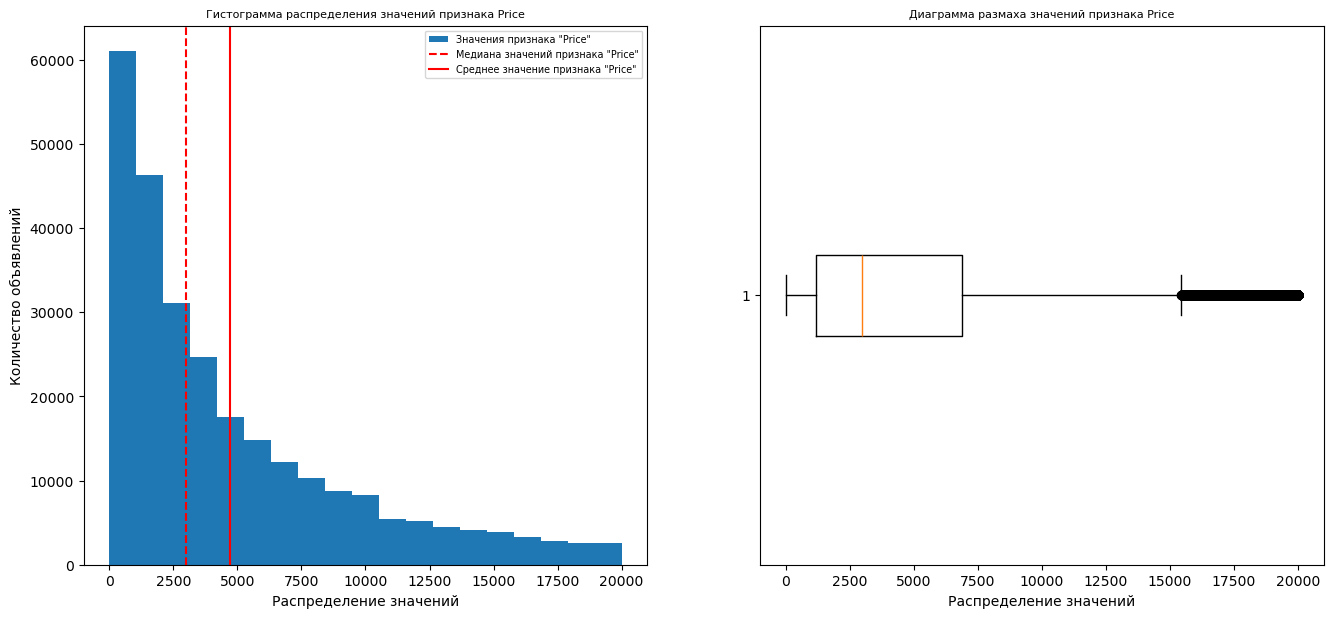

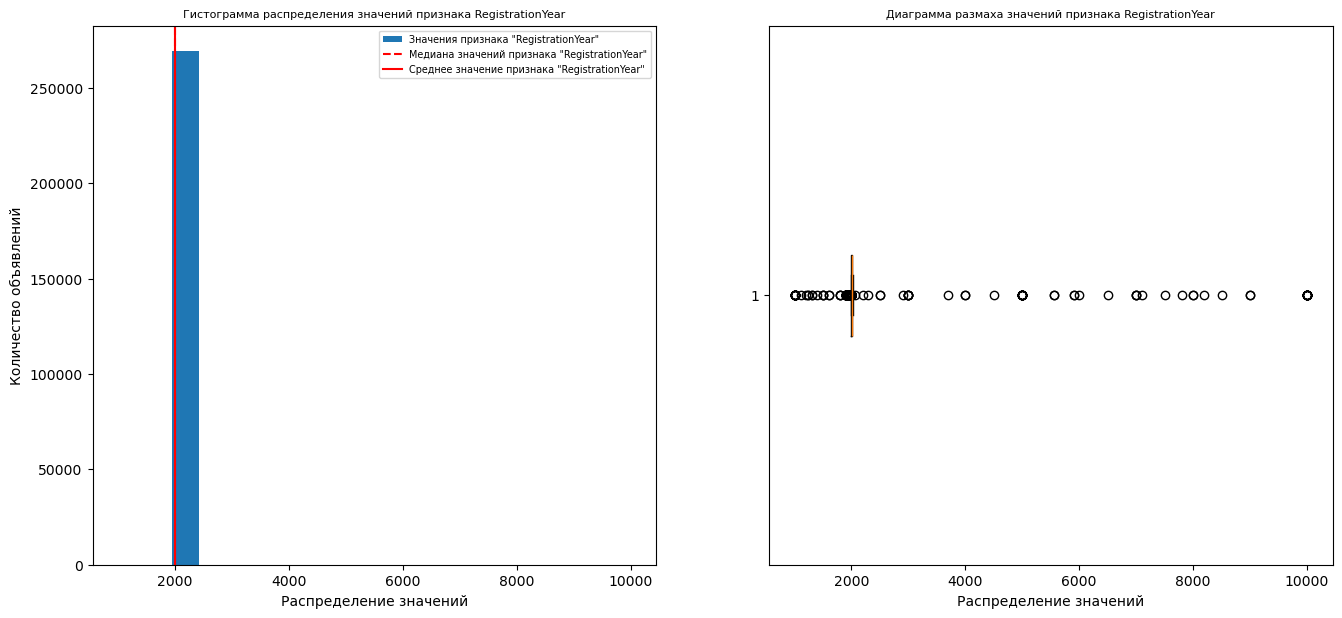

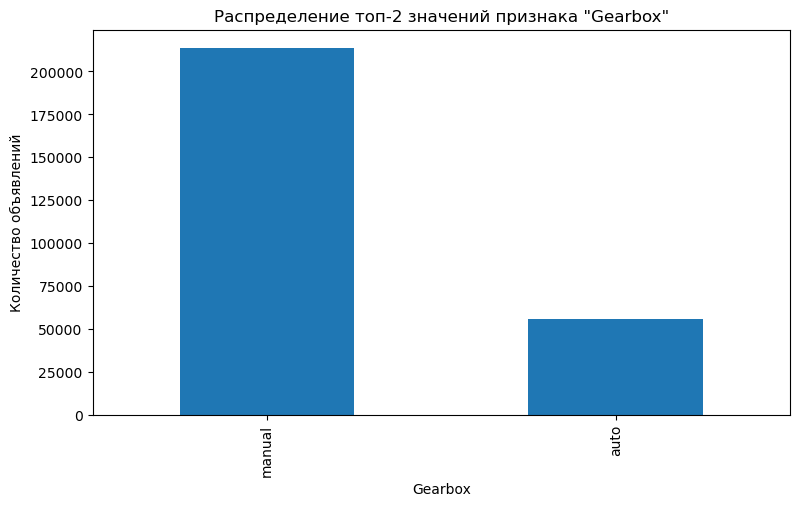

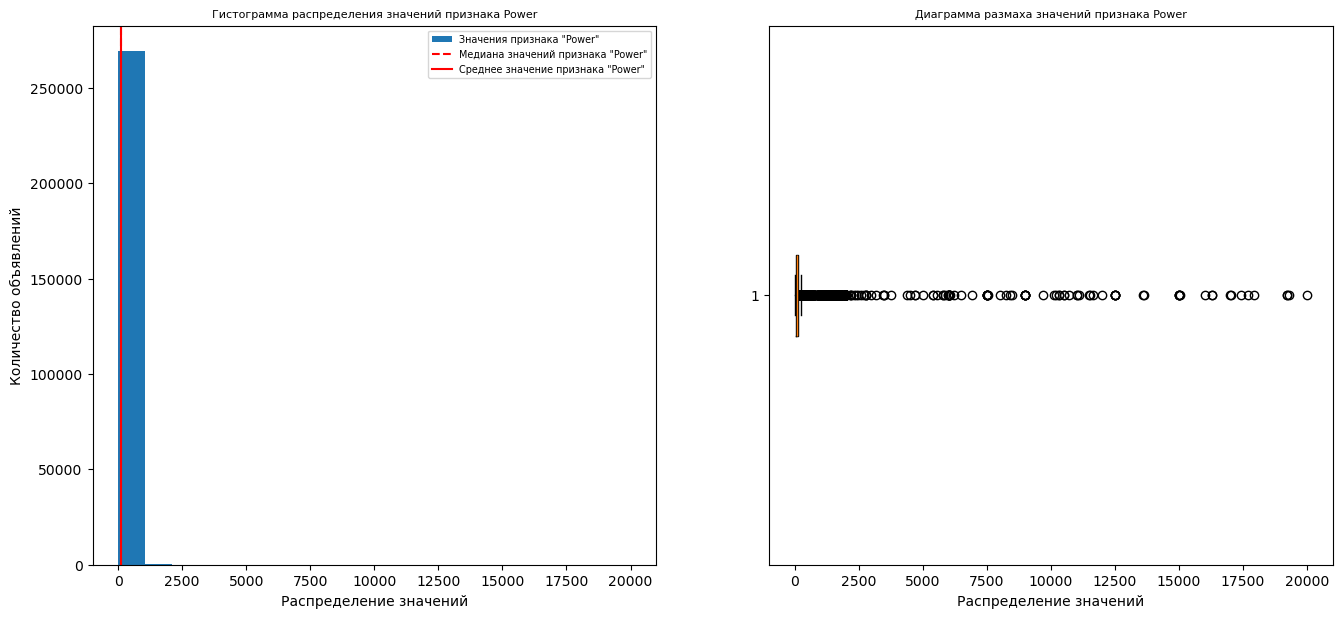

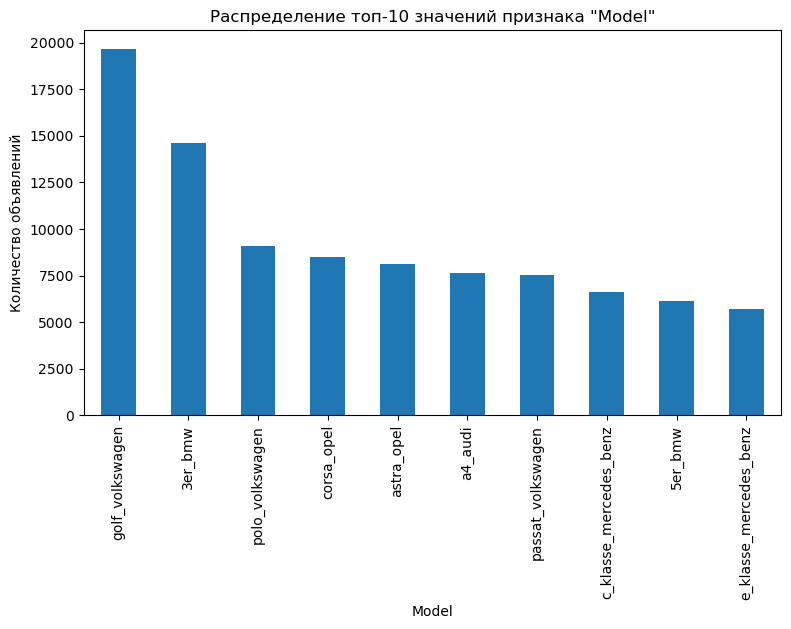

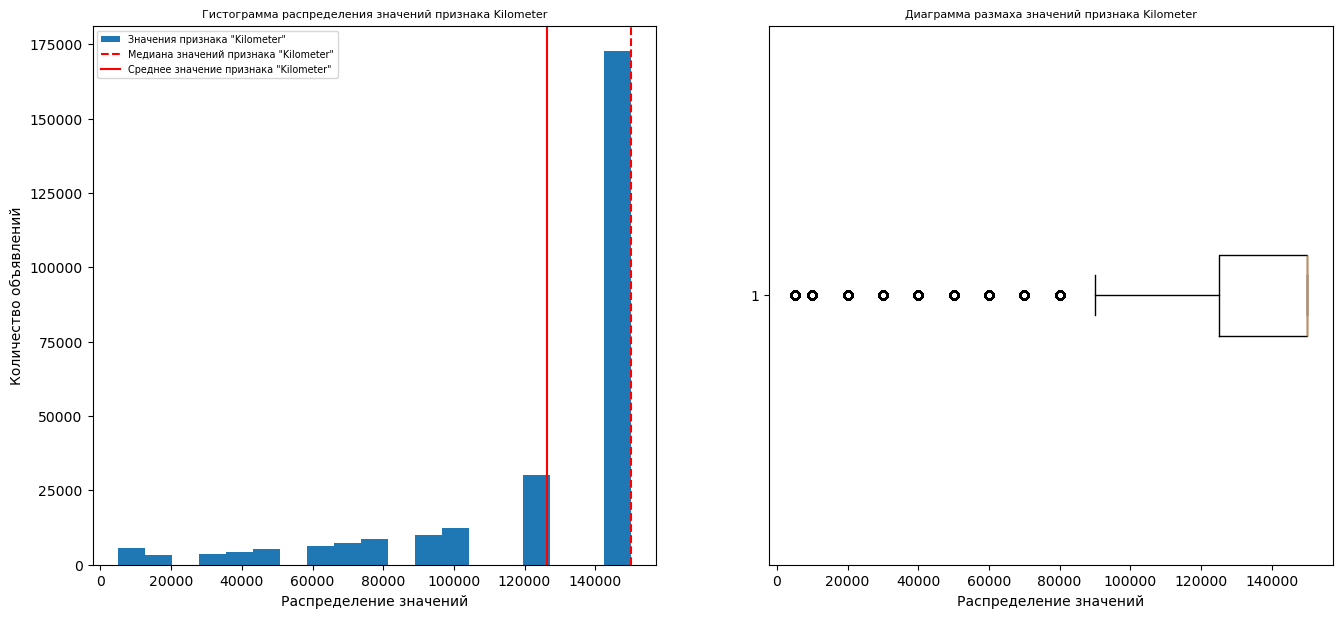

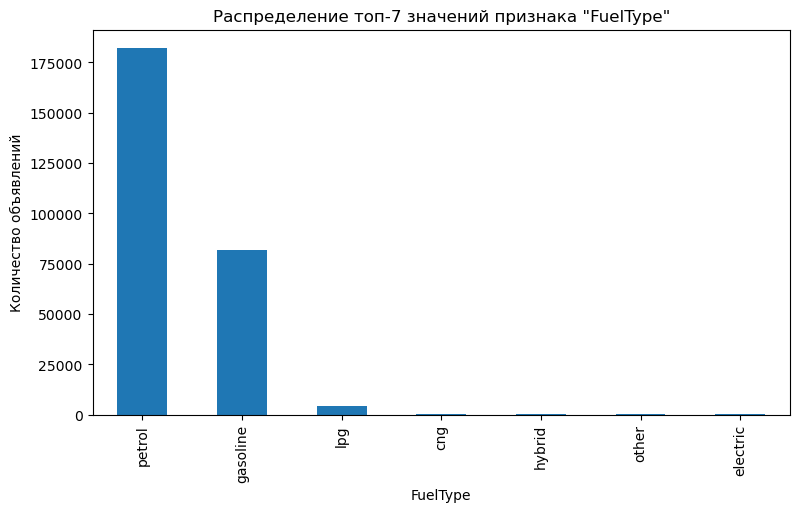

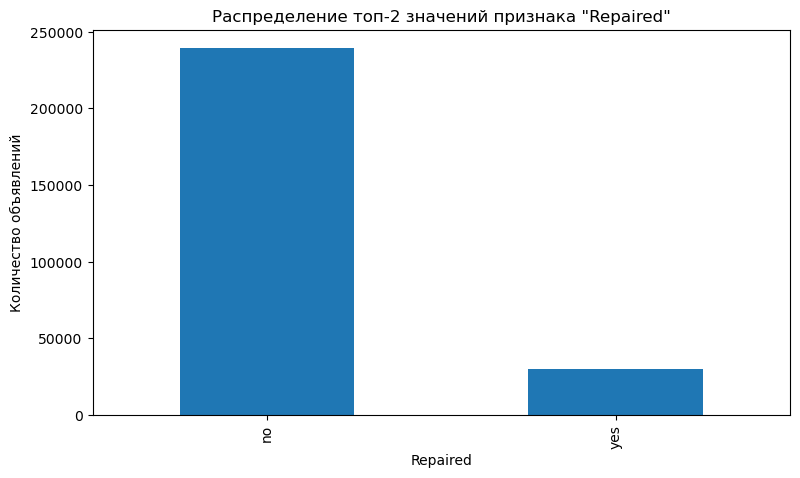

In [16]:
def make_plot(frame):
    # Оптимальное число корзин по правилу Квиксола
    bins = int(log(frame.shape[0], 2)) + 1
    # Проходим циклом по колонкам фрейма
    for column in frame.columns:
        # Для нечисловых значений строим столбчатый график
        if frame[column].dtype == 'object':
            plt.figure(figsize=(9, 5))
            plt.ylabel('Количество объявлений')
            plt.xlabel(f'Значения признака {column}')
            (
                frame[column].value_counts()
                             .sort_values(ascending=False)
                             .head(10)
                             .plot(
                                 kind='bar',
                                 title=f'Распределение топ-{min(10, len(frame[column].value_counts().index))} значений признака "{column}"'
                             )
            )
        # Для числовых значений - гистограмму распределения и ящик с усами
        else:
            # Делим на две зоны
            fig, axs = plt.subplots(1, 2, figsize=(16, 7))
            # Гистограмма
            axs[0].hist(filtered_data[column],
                        bins=bins,
                        label=f'Значения признака "{column}"')
            # Вертикальная линия медианного значения
            axs[0].axvline(frame[column].median(),
                           color='red',
                           linestyle='--',
                           label=f'Медиана значений признака "{column}"')
            # Вертикальная линия среднего значения
            axs[0].axvline(frame[column].mean(),
                           color='red',
                           linestyle='-',
                           label=f'Среднее значение признака "{column}"')
            # Описание графика
            axs[0].legend(loc='best', fontsize='x-small')
            axs[0].set_ylabel('Количество объявлений')
            axs[0].set_xlabel('Распределение значений')
            axs[0].set_title(f'Гистограмма распределения значений признака {column}', fontsize=8)

            # Ящик с усами
            axs[1].boxplot(frame[column],
                           vert=False)
            # Описание графика
            axs[1].set_xlabel('Распределение значений') 
            axs[1].set_title(f'Диаграмма размаха значений признака {column}', fontsize=8)

        # Выводим график
        plt.show()

make_plot(filtered_data)

В фрейме присутствуют множество выбросов. Избавимся от следующих выбросов:
- Ограничим год регистрации - 1950 и текущим (2024)
- Мощность - 2000 л.с.
- Километраж - не менее 85000

<span id='err_1'>Также стоит удалить объявления с ценой 0, так как они будут потенциально смещать прогноз

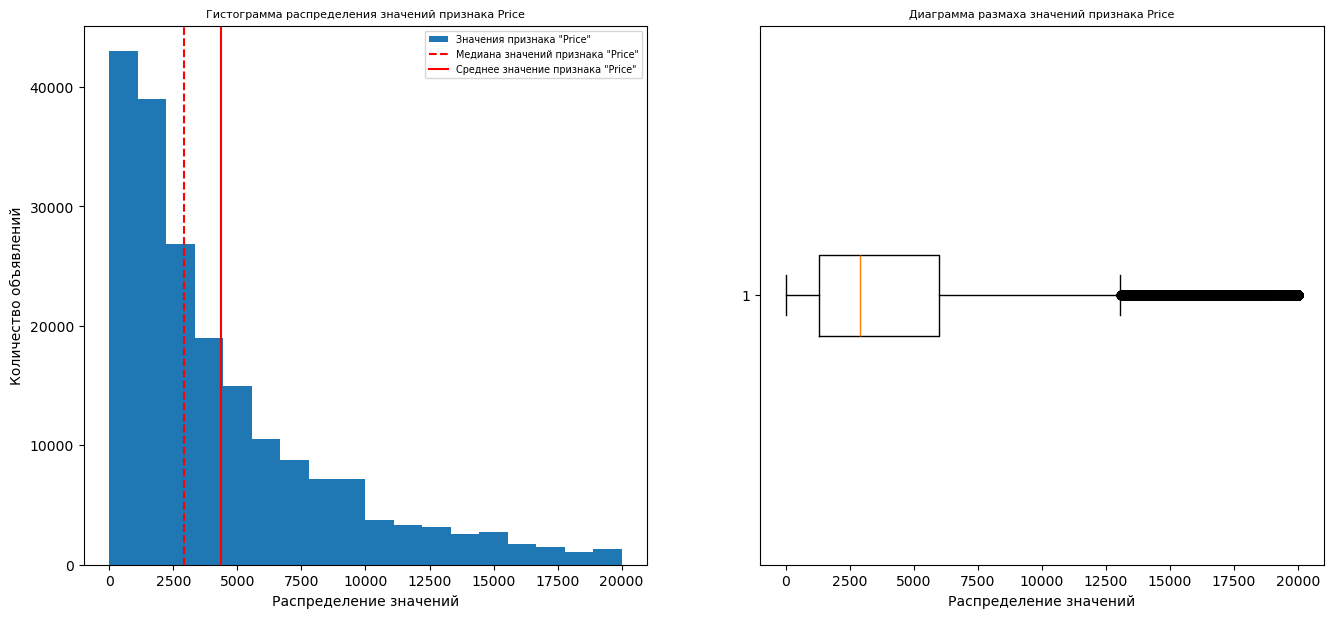

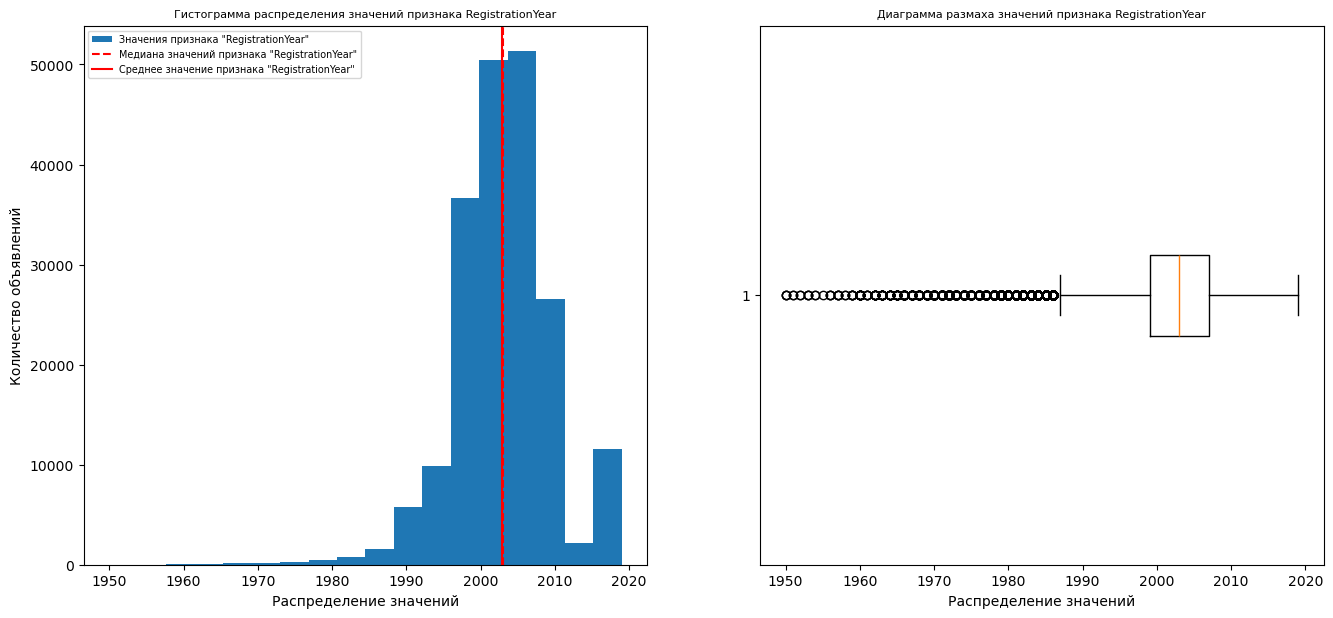

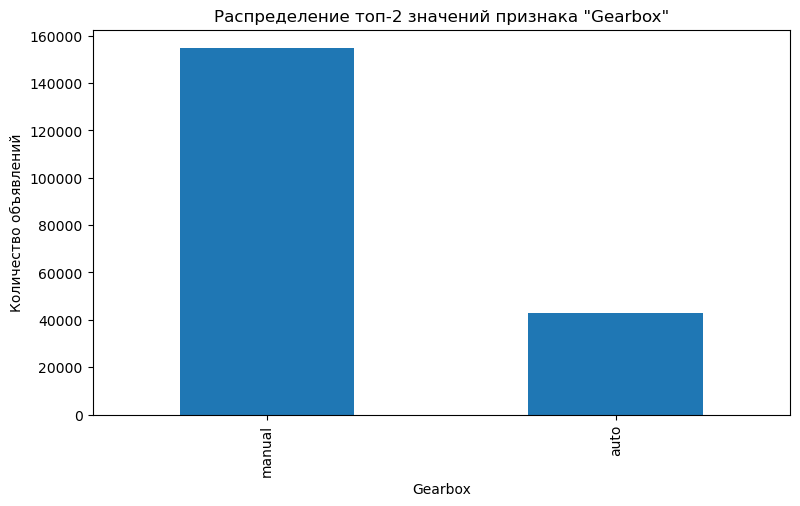

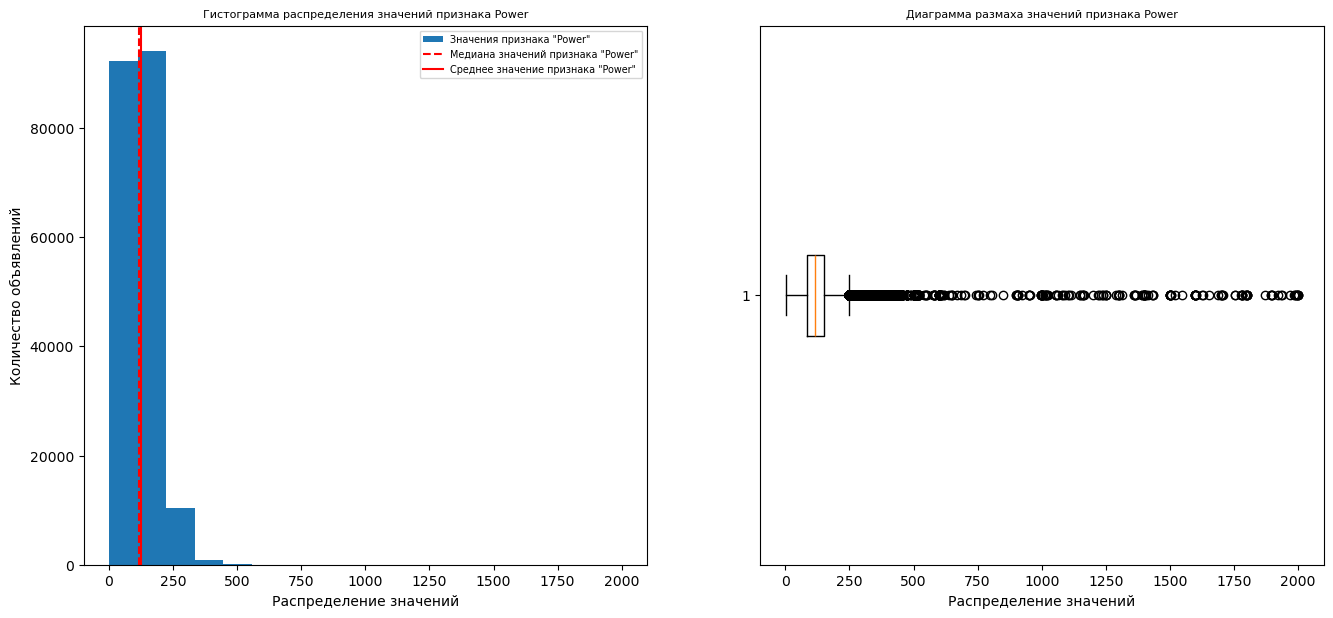

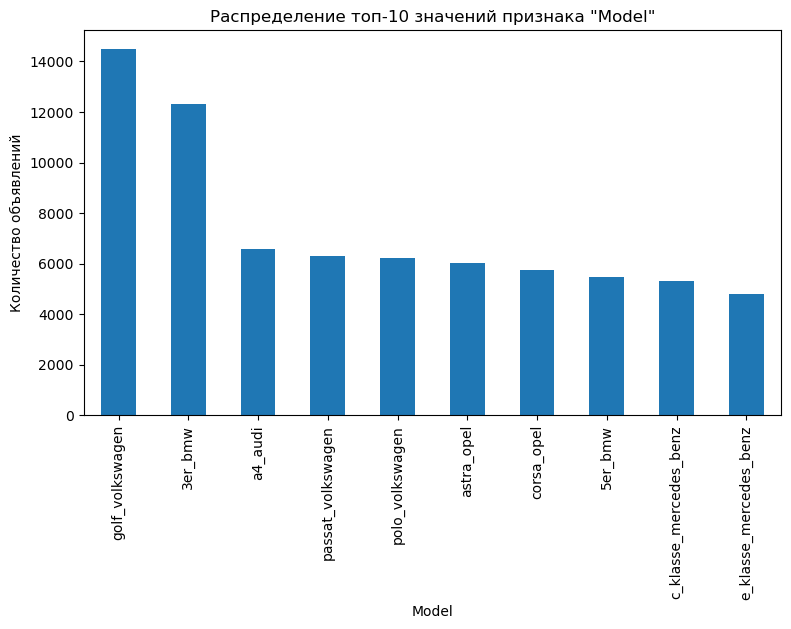

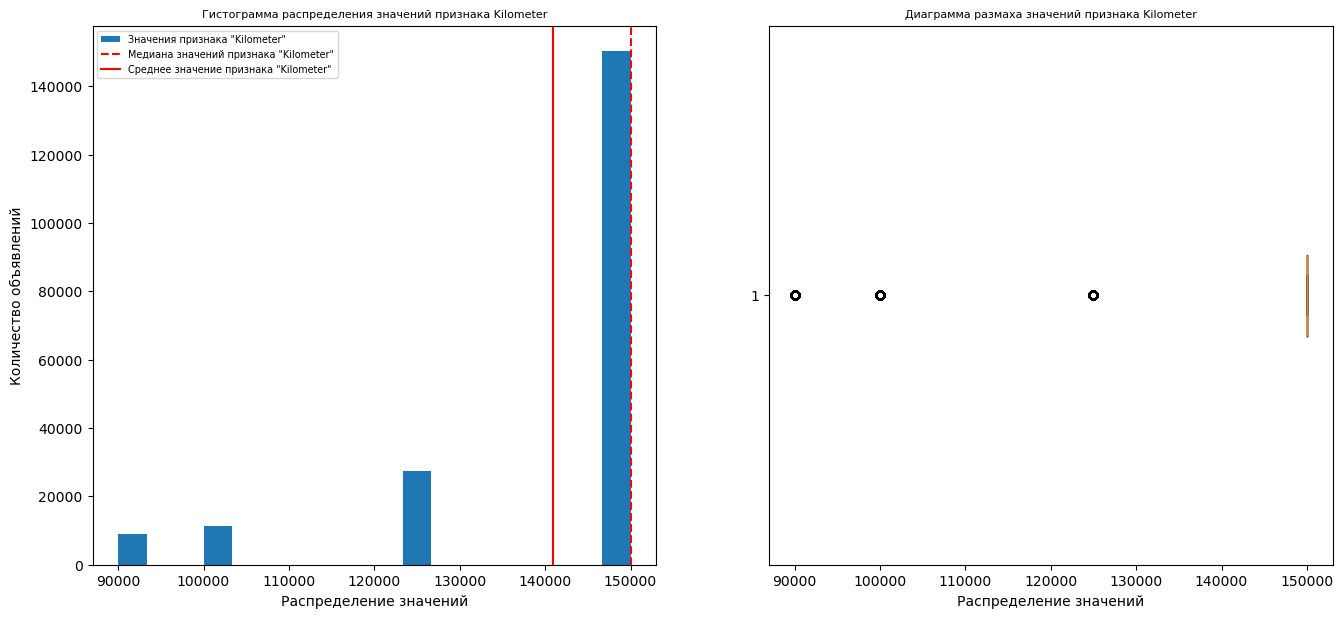

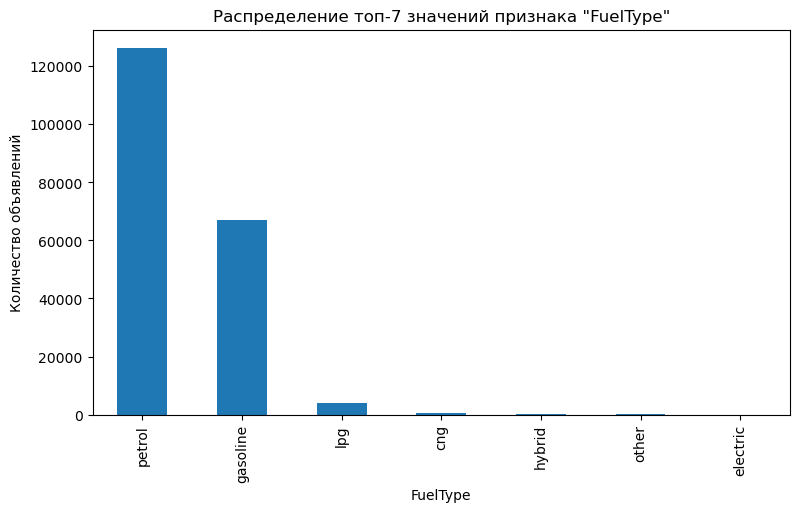

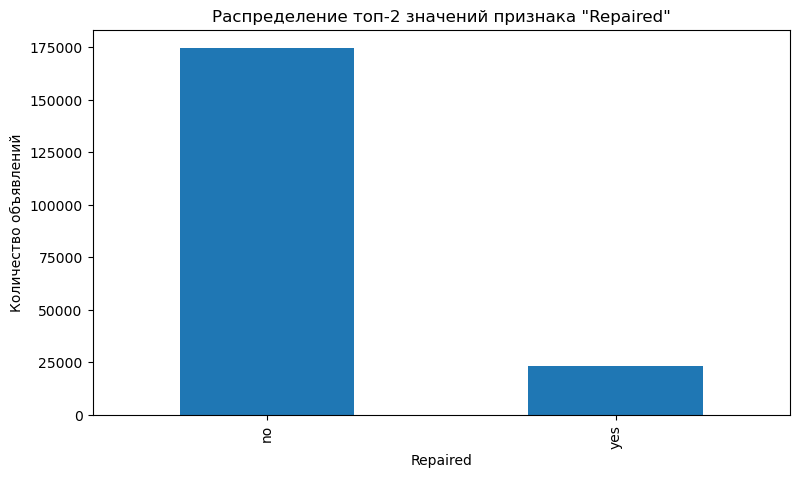

In [17]:
# Удаляем выбросы
filtered_data = filtered_data.query('1950 <= RegistrationYear <= 2024 and 0 < Power <= 2000 and Kilometer >= 85000 and Price > 0')

# Проводим повторное построение графиков
make_plot(filtered_data)

***Вывод:*** Таким образом, среднестатистическая машина в объявлении:
- Продается по цене 2500
- Зарегистрирована в 2003 году
- С ручной коробкой передач
- Мощностью 120 л.с.
- Пробегом 150000 км
- С типом топлива бензин
- Не была в ремонте

### Корреляционный анализ

Корреляционный анализ проведем с помошью матрицы корреляции

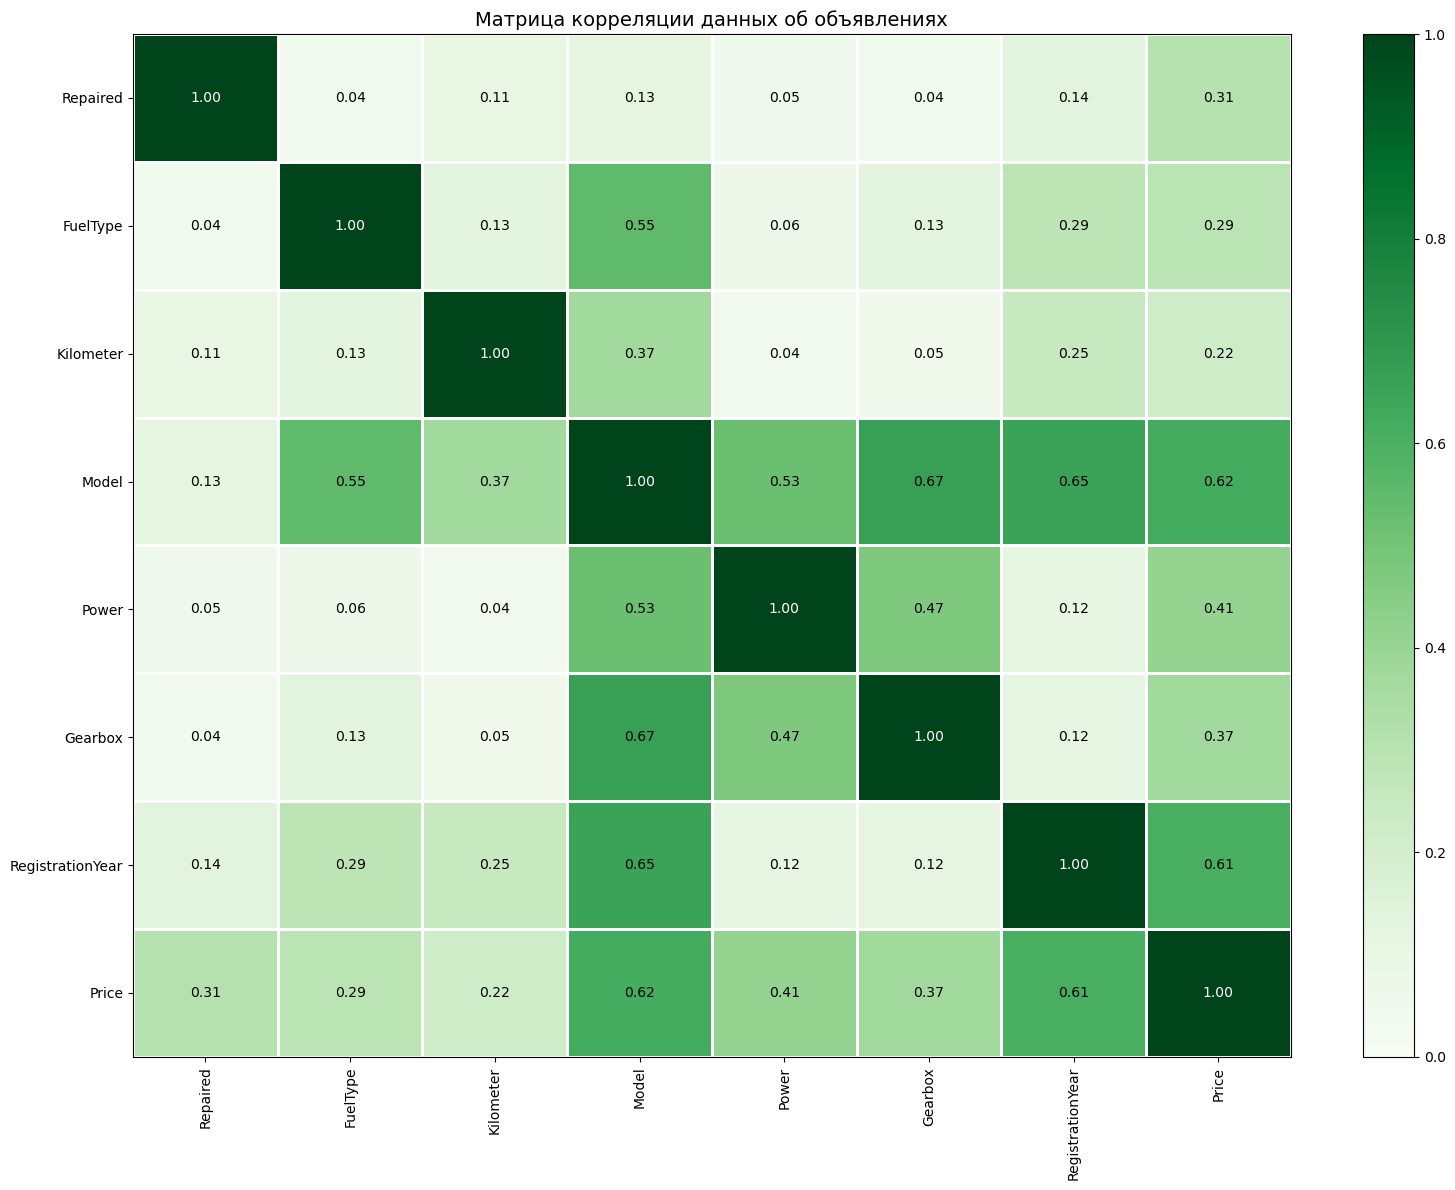

In [18]:
# Создаем матрицу корреляции
phik_overview = phik_matrix(filtered_data,
                            interval_cols=['Price', 'RegistrationYear', 'Power', 'Kilometer'])

# Визуализируем матрицу
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map='Greens',
    title='Матрица корреляции данных об объявлениях',
    figsize=(16, 12)
) 

***Вывод:*** Согласно данной матрице корреляций наиболее коррелирующими входными признаками являются `Model` и `RegistrationYear`. Мультиколлинеарность не обнаружена

### Вывод предобработки
Была произведена загрузка данных и ее предобработка.
Согласно исследовательскому анализу данных среднестатистической машиной объявления является:
- Продается по цене 2500
- Зарегистрирована в 2003 году
- С ручной коробкой передач
- Мощностью 120 л.с.
- Пробегом 150000 км
- С типом топлива бензин
- Не была в ремонте
При корреляционном анализе было выявлено, что наиболее коррелирующими входными признаками являются `Model` и `RegistrationYear`. Мультиколлинеарность не обнаружена

## Обучение моделей

В данной части необходимо разработать и обучить несколько моделей МО и сохранить время обучения модели. Я использую модели линейной регрессии, `LightGBM` и `CatBoostRegressor`. В качестве метрики будетм использовать `RMSE` метрику. Начнем с разбиения фрейма на тестовую и тренировочную выборки

In [19]:
# Закрепим разбиение
RANDOM_STATE = 49
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    filtered_data.drop('Price', axis=1),
    filtered_data.Price,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

### Линейная регрессия

Для данной модели построим пайплайн, в котором произведем предобработку данных (кодирование категориальных признаков и масштабирование количественных признаков) и обучение модели. Проведем кросс-валидацию модели для поиска лучшего набора гиперпараметров. Начнем с пайплайна предобработки

In [20]:
data_preprocessor = ColumnTransformer(
    [
        (
            'cat',
            OneHotEncoder(
                categories='auto',
                handle_unknown='ignore',
                sparse_output=False,
                drop='first'
            ),
            cat_columns
        ),
        (
            'quan',
            MinMaxScaler(),
            [x for x in quan_cols if x != 'Price']
        )
    ]
)

Соберем общий пайплайн модели. Добавим отбор признаков.

In [21]:
# Общий пайплайн
pipe = Pipeline(
    [
        (   # Предобработка данных
            'preprocessor',
            data_preprocessor
        ),
        (   # Отбор признаков
            'skb',
            SelectKBest(f_regression, k=2)
        ),
        (   # Алгоритм прогнозирования
            'model',
            LinearRegression()
        )
    ]
)

Зададим распределение гиперпараметров модели

In [22]:
lr_model_params = {
    'skb__k': range(2, 11),
    'preprocessor__quan': [
        StandardScaler(),
        MinMaxScaler(),
        RobustScaler()
    ]        
}

Удалим ненужные переменные, так как Kernel ложится

In [23]:
del raw_data
del filtered_data

Применим кросс валидацию для поиска лучшего набора гиперпараметров. 

In [24]:
search = RandomizedSearchCV(
    pipe, 
    param_distributions=lr_model_params, 
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    cv=5,
    n_jobs=-1
).fit(
    X_train,
    y_train
)

Оценим качество модели на значении ее метрики. Выведем среднее время обучения модели, среднее время предсказания и метрику `RMSE`

In [25]:
# Собираем необходимые данные в один фрейм
lr_results = (pd.DataFrame(search.cv_results_)
                .query('rank_test_score == 1')
                [['mean_fit_time','mean_score_time', 'mean_test_score']])

# Переименуем колонки и преобразуем данные RMSE для читаемости
lr_results.columns = ['Fit Time', 'Score Time', 'RMSE']
lr_results.RMSE = - lr_results.RMSE

# Добавим колоку Model для последующего сравнения моделей
lr_results = lr_results.assign(Model=['LinearRegression']).set_index('Model')

# Представим таблицу
lr_results

,Fit Time,Score Time,RMSE
Model,,,
LinearRegression,2.756784,0.379654,3007.847756


Данная модель не удовлетворяет требованиям заказчика. Возможно, она была бы лучше при использовании полиномиальных признаков, однако Kernel ложится даже при 2 степени.

### LightGMB

Для данной модели следует провести предобработку данных и обучить модель на целевую метрику. Копируем датасет

In [26]:
X_train_lgbm = X_train.copy()

for c in cat_columns:
    X_train_lgbm[c] = X_train_lgbm[c].astype('category')

Зададим параметры модели

In [27]:
lgmb_model_params = {
    'num_leaves': range(2, 6),
    'max_depth': range(2, 11)    
}

Применим кросс валидацию для поиска лучшего набора гиперпараметров. 

In [28]:
search_lgmb = RandomizedSearchCV(
    LGBMRegressor(
        objective='rmse',
        random_state=RANDOM_STATE,
        categorical_feature=cat_columns
    ), 
    param_distributions=lgmb_model_params, 
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    cv=5,
    n_jobs=-1
).fit(
    X_train_lgbm,
    y_train
)

c:\Users\odnoromanenko\AppData\Local\anaconda3\Lib\site-packages\lightgbm\basic.py:2034: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
c:\Users\odnoromanenko\AppData\Local\anaconda3\Lib\site-packages\lightgbm\basic.py:2054: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] categorical_feature is set=Gearbox,Model,FuelType,Repaired, categorical_column=1,3,5,6 will be ignored. Current value: categorical_feature=Gearbox,Model,FuelType,Repaired
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 593
[LightGBM] [Info] Number of data points in the train set: 148318, number of used features: 7
[LightGBM] [Info] Start training from score 4369.460996


Выведем метрики лучшей модели

In [29]:
# Собираем необходимые данные в один фрейм
lgbm_results = (pd.DataFrame(search_lgmb.cv_results_)
                .query('rank_test_score == 1')
                [['mean_fit_time','mean_score_time', 'mean_test_score']])

# Переименуем колонки и преобразуем данные RMSE для читаемости
lgbm_results.columns = ['Fit Time', 'Score Time', 'RMSE']
lgbm_results.RMSE = - lgbm_results.RMSE

# Добавим колоку Model для последующего сравнения моделей
lgbm_results = lgbm_results.assign(Model=['LightGBM Regression']).set_index('Model')

# Представим таблицу
lgbm_results

,Fit Time,Score Time,RMSE
Model,,,
LightGBM Regression,2.346486,0.073268,1764.903125


Таким образом, метрика `RMSE` данной модели выше, а время прогноза ниже, чем у `LinearRegresion`, однако время обучения почти в два раза выше

### CatBoostRegressor

Для данной модели нет необходимости преобразовывать входные признаки, так что можем сразу начать с кросс-валидации. Для сравнения с `LightGBM` примем такие же параметры для кросс валидации

**Замечание:** в `CatBoost` есть внутренняя кросс валидация, однако по заданию необходимо сравнить скорость обучения и предсказания, для чего лучше подойдет `RandomizedSeachCV`

In [30]:
# Задаем модель
model_cb = CatBoostRegressor(
    random_state=RANDOM_STATE,
    cat_features=cat_columns,
    grow_policy='Lossguide',
    silent=True
)

# Проводим кросс валидацию
search_cb = RandomizedSearchCV(
    model_cb, 
    param_distributions=lgmb_model_params, 
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    cv=5,
    n_jobs=-1
).fit(
    X_train,
    y_train
)

Выведем метрики лучшей модели

In [31]:
# Собираем необходимые данные в один фрейм
cb_results = (pd.DataFrame(search_cb.cv_results_)
                .query('rank_test_score == 1')
                [['mean_fit_time','mean_score_time', 'mean_test_score']])

# Переименуем колонки и преобразуем данные RMSE для читаемости
cb_results.columns = ['Fit Time', 'Score Time', 'RMSE']
cb_results.RMSE = - cb_results.RMSE

# Добавим колоку Model для последующего сравнения моделей
cb_results = cb_results.assign(Model=['CatBoost Regression']).set_index('Model')

# Представим таблицу
cb_results

,Fit Time,Score Time,RMSE
Model,,,
CatBoost Regression,208.614757,0.514743,1765.102145


## Анализ моделей

Соберем все показатели моделей в один фрейм для сравнения

In [32]:
pd.concat([lr_results, lgbm_results, cb_results])

,Fit Time,Score Time,RMSE
Model,,,
LinearRegression,2.756784,0.379654,3007.847756
LightGBM Regression,2.346486,0.073268,1764.903125
CatBoost Regression,208.614757,0.514743,1765.102145


***Вывод:*** По данной таблице видно, что самое быстрое обучение у модели LinearRegression, однако она показала худшее качество из трех моделей. Лучшее качество имеет модель `LightGBM`, время обучения данной модели почти в два раза выше `LinearRegression`, однако оно удовлетворяет требованиям заказчика

Оценим работу лучшей модели (`LightGBM`) на тестовых данных. Сначала сделаем техническое преобразование тестовой выборки

In [33]:
X_test_lgbm = X_test.copy()

for c in cat_columns:
    X_test_lgbm[c] = X_test_lgbm[c].astype('category')

Выведем значение метрики на тестовых данных

In [34]:
%%time
print('RMSE лучшей модели на тестовых данных равно:', root_mean_squared_error(y_test, search_lgmb.best_estimator_.predict(X_test_lgbm)))

RMSE лучшей модели на тестовых данных равно: 1780.7692972828281
CPU times: total: 422 ms
Wall time: 131 ms


Проведем анализ важности признаков лучшей модели

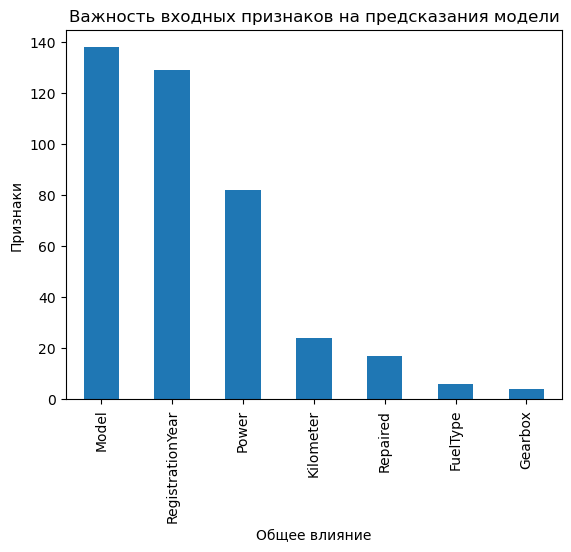

In [35]:
(
    pd.Series(search_lgmb.best_estimator_.feature_importances_, index=search_lgmb.best_estimator_.feature_name_)
      .sort_values(ascending=False)
      .plot(kind='bar',
            title='Важность входных признаков на предсказания модели',
            ylabel='Признаки',
            xlabel='Общее влияние')
)

plt.show()

Как сы видим, цена больше всего зависит от модели/бренда машины, к сожалению ансамбль `LightGBM` не дает точно понять, какие модели/бренды стоятдороже на рынке, однако мы можем оценить влияние количественных признаков с помощью библиотеки `SHAP` 

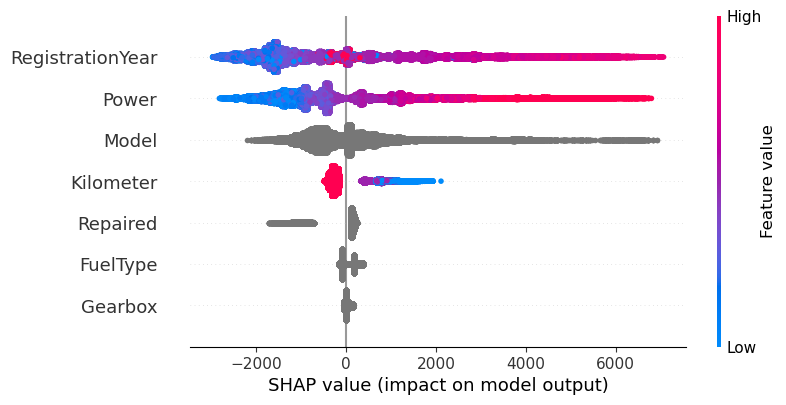

In [36]:
explainer = shap.Explainer(search_lgmb.best_estimator_, feature_perturbation="tree_path_dependent")
shap_values = explainer(X_train_lgbm)

shap.plots.beeswarm(shap_values)

По данному графику видно, что стоимость машины обратно зависит от ее возраста и пробега, прямо - от ее мощности. Также можно предположить, что машины, не проходившие ремонт стоят выше, однако для подтверждения данного предположения стоит провести дополнительные исследования

## Общий вывод

Таким образом в данном проекте были проанализированы данные по объявлениям по машинам, с целью прогнозирования рыночной стоимости автомобиля. В ходе проекта были произведены следующие шаги:

- Загрузка и первичный анализ данных
- Предобработка данных
- Исследовательский анализ данных
- Обучение моделей и поиск лучшей

По результату модели было выявлено, что самое быстрое обучение у модели `LinearRegression`, однако она показала худшее качество из трех моделей. Лучшее качество имеет модель `LightGBM`, время обучения данной модели почти в два раза выше `LinearRegression`, однако оно удовлетворяет требованиям заказчика. **Рекомендация:** модели `CatBoost` и `LightGBM` имеют относительно равные метрики RMSE в данном проекте. Однако руководству предлагается использовать модель `LightGBM`, так как данная модель имеет меньшее время обучения и предсказания

По анализу лучшей модели было выявлено, что на стоимость машины более всего влияют признаки модель/бренд, возраст (обратная зависимость) и мощность машины (прямая зависимость)